In [18]:
from dasly import das_master
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib import colors
import pandas as pd

from dasly.simpledas import simpleDASreader

import math
from typing import Literal, Union
import logging
import logging.config

import numpy as np
import pandas as pd
import cv2
from sklearn.cluster import DBSCAN

In [2]:
# from dasly_p import dasly
from dasly.das_loader import DASLoader
from dasly.das_filter import DASFilter
from dasly.das_plotter import DASPlotter
from dasly.das_sampler import DASSampler
from dasly.das_analyzer import DASAnalyzer

In [42]:
das = das_master.Dasly()
das.load_data(
    folder_path='/media/kptruong/yellow02/Aastfjordbrua/Aastfjordbrua/',
    # folder_path='/media/kptruong/yellow02/Aastfjordbrua/',
    # start='20231005 094345',
    # start='20230901 103015',  # full 2 lines
    # start='20231005 082445',
    # start='20230901 163110',  # part of a line
    # start='20231005 082445',
    # start='20230901 183015',  # noise
    # start='20230901 104015',  # 2 cars close to each other
    start='20230724 175906',
    duration=60,
    integrate=False
)


6 files, from 175906 to 175956


vmin: -5.88e-06, vmax: 5.88e-06


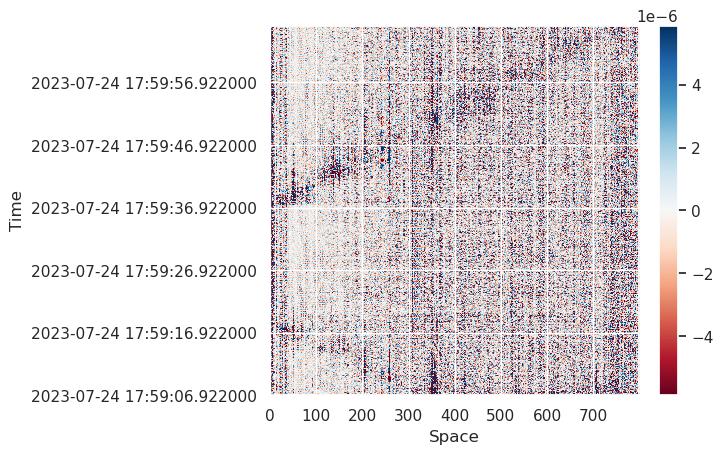

In [43]:
das.heatmap()

In [44]:
das = das_master.Dasly()
das.load_data(
    folder_path='/media/kptruong/yellow02/Aastfjordbrua/Aastfjordbrua/',
    # folder_path='/media/kptruong/yellow02/Aastfjordbrua/',
    # start='20231005 094345',
    # start='20230901 103015',  # full 2 lines
    # start='20231005 082445',
    # start='20230901 163110',  # part of a line
    # start='20231005 082445',
    # start='20230901 183015',  # noise
    # start='20230901 104015',  # 2 cars close to each other
    start='20230724 175916',
    duration=60,
    integrate=False
)


7 files, from 175906 to 180006


vmin: -5.74e-06, vmax: 5.74e-06


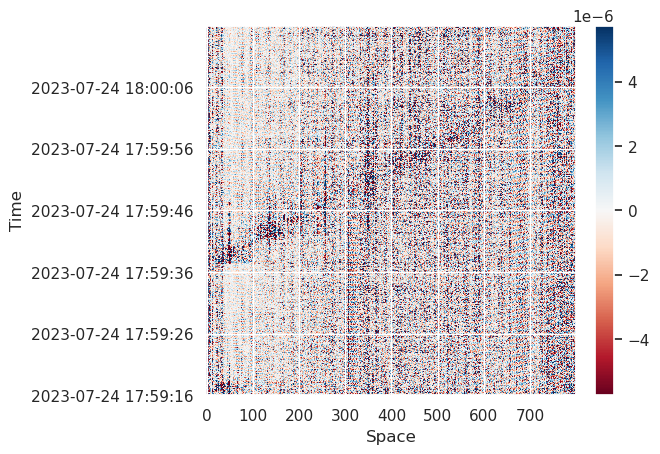

In [45]:
das.heatmap()

Signal updated with low-pass filter.
Signal updated with new temporal sampling rate 8.
Signal updated with Gaussian smoothing.
Signal updated with Sobel filter.
Signal updated with binary transform with threshold 2.6e-08.


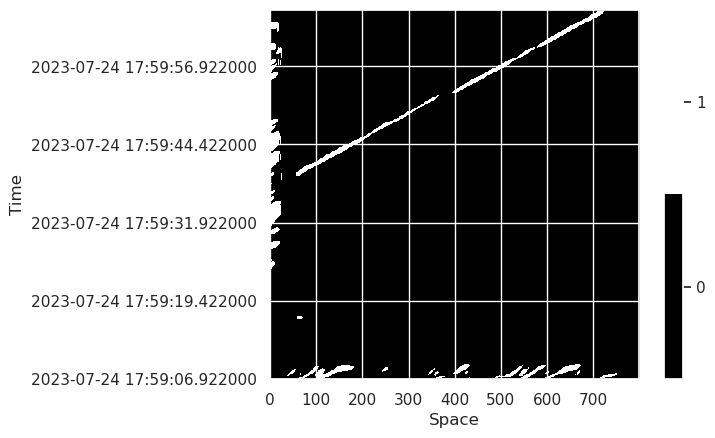

In [5]:
das.reset()
das.lowpass_filter(0.5)
das.decimate(t_rate=6)
das.gaussian_smooth(85, 90, std_s=10)
# das.gaussian_smooth(-90, -85, std_s=10)
das.sobel_filter()
das.binary_transform(threshold=2.6e-08)  # 2.61e-08
das.heatmap()

3 lines are detected.


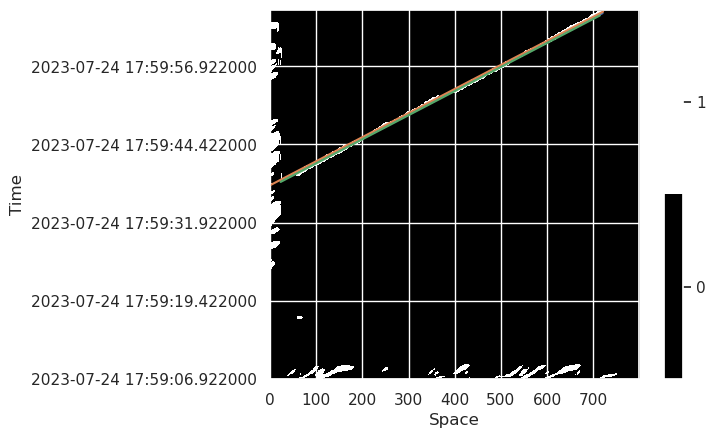

In [6]:
das.hough_transform(target_speed=90, speed_res=0.5, length_meters=600, threshold_percent=0.6, max_line_gap_percent=0.2)
das.heatmap()

In [30]:
eps_seconds = 1
eps = eps_seconds * das.t_rate
lines_distance_to_axis = das._y_vals_lines(
    das.lines,
    np.arange(das.signal.shape[1])
)

In [32]:
def _metric(x: np.ndarray, y: np.ndarray) -> Union[np.ndarray, float]:
    """Calculate the distance between lines in spatial-temporal data.
    It is the average distance by seconds or average distance by meters.

    Args:
        x (np.ndarray): Array of x values of shape (m, n) or (, n).
        y (np.ndarray): Array of y values of shape (p, n) or (, n).

    Returns:
        Union[np.ndarray, float]: Distance between lines.
    """
    # print(f'x: {x}')
    # print(f'y: {y}')
    print(f'x.shape: {x.shape}')
    print(f'y.shape: {y.shape}')
    # Check if x and y are one-dimensional
    x_is_1d = x.ndim == 1
    y_is_1d = y.ndim == 1

    # If both x and y are one-dimensional, reshape them to (1, d)
    if x_is_1d and y_is_1d:
        print('dim 1')
        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

    # Expand dimensions of x and y for broadcasting
    x_exp = np.expand_dims(x, axis=1)  # Shape (m, 1, n)
    y_exp = np.expand_dims(y, axis=0)  # Shape (1, p, n)

    # Replace the arbitrary number max int32 with nan
    ARB_NUM = np.iinfo(np.int32).max
    x = np.where(x == ARB_NUM, np.nan, x)
    y = np.where(y == ARB_NUM, np.nan, y)

    # Calculate absolute distance and handle NaNs
    abs_dist = np.abs(x_exp - y_exp)  # Shape (m, p, n)
    # Sum of non-nan values along the last axis, shape (m, p)
    sum_dist = np.nansum(abs_dist, axis=-1)
    # Count of non-nan values along the last axis, shape (m, p)
    count_non_nan = np.sum(~np.isnan(abs_dist), axis=-1)
    # Calculate mean distance
    mean_dist = np.where(
        count_non_nan > 0, sum_dist / count_non_nan, ARB_NUM)

    if x_is_1d and y_is_1d:
        print(f'mean_dist: {mean_dist[0, 0]}')
        return mean_dist[0, 0]
    print(f'mean_dist: {mean_dist}')
    return mean_dist

In [25]:
x = lines_distance_to_axis[0]
y = lines_distance_to_axis[1]
_metric(x, y)

x.shape: (800,)
y.shape: (800,)
dim 1
mean_dist: 61740148.870687485


61740148.870687485

In [37]:
x = lines_distance_to_axis[0]
y = lines_distance_to_axis[1]

print(f'x.shape: {x.shape}')
print(f'y.shape: {y.shape}')
# Check if x and y are one-dimensional
x_is_1d = x.ndim == 1
y_is_1d = y.ndim == 1

# If both x and y are one-dimensional, reshape them to (1, d)
if x_is_1d and y_is_1d:
    print('dim 1')
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)

# Expand dimensions of x and y for broadcasting
x_exp = np.expand_dims(x, axis=1)  # Shape (m, 1, n)
y_exp = np.expand_dims(y, axis=0)  # Shape (1, p, n)

# Replace the arbitrary number max int32 with nan
ARB_NUM = np.iinfo(np.int32).max
x = np.where(x == ARB_NUM, np.nan, x)
y = np.where(y == ARB_NUM, np.nan, y)

# # Calculate absolute distance and handle NaNs
# abs_dist = np.abs(x_exp - y_exp)  # Shape (m, p, n)
# # Sum of non-nan values along the last axis, shape (m, p)
# sum_dist = np.nansum(abs_dist, axis=-1)
# # Count of non-nan values along the last axis, shape (m, p)
# count_non_nan = np.sum(~np.isnan(abs_dist), axis=-1)
# # Calculate mean distance
# mean_dist = np.where(
#     count_non_nan > 0, sum_dist / count_non_nan, ARB_NUM)

x.shape: (800,)
y.shape: (800,)
dim 1


In [39]:
x_exp.shape

(1, 1, 800)

In [9]:
das.dbscan(eps_seconds=1)

x.shape: (800,)
y.shape: (800,)
dim 1
mean_dist: 61740148.870687485
x.shape: (800,)
y.shape: (800,)
dim 1
mean_dist: 16106124.777817434
x.shape: (800,)
y.shape: (800,)
dim 1
mean_dist: 77846273.623125
x.shape: (800,)
y.shape: (800,)
dim 1
mean_dist: 0.0
x.shape: (800,)
y.shape: (800,)
dim 1
mean_dist: 0.0
x.shape: (800,)
y.shape: (800,)
dim 1
mean_dist: 0.0
[[2.14748365e+09 2.14748365e+09 2.14748365e+09 ... 2.14748365e+09
  2.14748365e+09 2.14748365e+09]
 [2.14748365e+09 2.48000000e+02 2.48308333e+02 ... 2.14748365e+09
  2.14748365e+09 2.14748365e+09]
 [2.14748365e+09 2.14748365e+09 2.14748365e+09 ... 2.14748365e+09
  2.14748365e+09 2.14748365e+09]]
(3, 800)
[0 1 2]


In [10]:
das.lines

array([[ 23, 253, 720, 468],
       [  1, 248, 721, 470],
       [ 23, 252, 714, 465]])

In [38]:
das._y_vals_lines(lines=das.lines, x_coords=np.arange(das.signal.shape[1])).shape

(17, 800)

In [85]:
2.14748365e+09

2147483650.0

In [86]:
das.lines

array([[ 23, 253, 720, 468],
       [  1, 248, 721, 470],
       [ 23, 252, 714, 465]], dtype=int32)

In [87]:
a = das._metric(das.lines[0], das.lines[1])

x: (4,), y: (4,)
x replace: (4,), y replace: (4,)
x_exp: (4, 1), y_exp: (1, 4)
abs_dist: (4, 4)
sum_dist: (4,)
count_non_nan: (4,)
mean_dist: (4,)


array([348. , 235.5, 360.5, 235.5])

In [90]:
das.lines[0].shape

(4,)

In [93]:
np.array([0, 1, 3]).shape

(3,)

In [96]:
np.array([0, 1, 3]).reshape(1, -1)

array([[0, 1, 3]])

In [41]:
np.empty((0, 4))

array([], shape=(0, 4), dtype=float64)

In [7]:
das.lines

array([], shape=(0, 4), dtype=float64)

In [8]:
das._lines_df()

AttributeError: Can only use .dt accessor with datetimelike values

In [9]:
das.dbscan(eps_seconds=1)
das.heatmap()

ValueError: Found array with 0 sample(s) (shape=(0, 800)) while a minimum of 1 is required by DBSCAN.

In [74]:
lines = np.empty((1, 4))
lines.shape

(1, 4)

In [75]:
das.lines
print(das.lines.shape)

(5, 4)


In [76]:
np.concatenate((lines, das.lines), axis=0)


array([[501.6 ,  52.8 , 520.08, 422.4 ],
       [ 28.  ,   1.  , 749.  , 257.  ],
       [ 13.  , 452.  , 752.  , 453.  ],
       [ 98.  ,   0.  , 759.  , 246.  ],
       [ 43.  , 106.  , 750.  , 361.  ],
       [ 26.  ,   2.  , 749.  ,  12.  ]])

In [1]:
import os

db_username = os.getenv('POSTGRESQL_USERNAME')
db_password = os.getenv('POSTGRESQL_PASSWORD')

In [4]:
import os
for key, value in os.environ.items():
    print(f'{key}: {value}')

USER: kptruong
SSH_CLIENT: 10.50.195.53 50539 22
LC_TIME: nb_NO.UTF-8
XDG_SESSION_TYPE: tty
SHLVL: 2
LD_LIBRARY_PATH: /opt/madagascar/lib:/opt/madagascar/lib::/usr/local/cuda/lib64:/usr/local/cuda/lib64
MOTD_SHOWN: pam
HOME: /home/kptruong
LC_MONETARY: nb_NO.UTF-8
SSL_CERT_FILE: /usr/lib/ssl/certs/ca-certificates.crt
DBUS_SESSION_BUS_ADDRESS: unix:path=/run/user/1013/bus
LOGNAME: kptruong
_: /home/kptruong/.conda/envs/kptruong/bin/python
XDG_SESSION_CLASS: user
VSCODE_CLI_REQUIRE_TOKEN: 4f5f4fdd-31b6-41da-8493-8e4df4f39fe9
XDG_SESSION_ID: 3729
PATH: /home/kptruong/.conda/envs/kptruong/bin:/home/kptruong/.vscode-server/cli/servers/Stable-f1e16e1e6214d7c44d078b1f0607b2388f29d729/server/bin/remote-cli:/home/kptruong/.local/bin:/opt/madagascar/bin:/opt/anaconda3/condabin:/opt/madagascar/bin:/usr/local/cuda/bin:/home/kptruong/.local/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/cwp/bin:.:/opt/cwp/bin:.
VSCODE_

vmax: 0.00836


(17, 41)


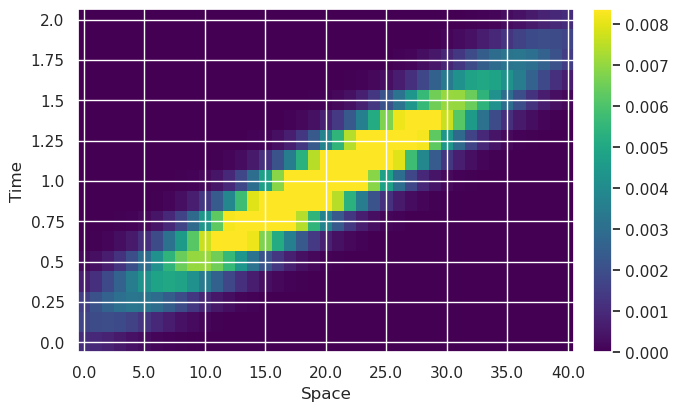

In [ ]:
print(das.gauss_kernel.shape)
das.heatmap(
    das.gauss_kernel,
    aspect=das.signal.shape[1]/das.signal.shape[0]
)

In [32]:
a = das.lines
b = das.lines[0:3] + das.lines[0:3]

In [8]:
database_table = 'a'
previous_bacth_id = (
        das.signal.index[0]
        .strftime('%Y-%m-%d %H:%M:%S')
)

query = (
    f'SELECT * FROM {database_table}' +
    f' WHERE batch_id = "{previous_bacth_id}";'
)
query

'SELECT * FROM a WHERE batch_id = "2023-09-01 10:40:15";'

In [14]:
das.signal.iloc[[0]][0].to_numpy()

array([0], dtype=uint8)

In [34]:
a_expanded = a[:, np.newaxis, :]  # Shape: (N, 1, K)
b_expanded = b[np.newaxis, :, :]  # Shape: (1, M, K)


distance_matrix = das._metric(a_expanded, b_expanded)
distance_matrix

array([[258.75, 577.25, 293.25],
       [325.  , 417.5 , 360.  ],
       [262.75, 595.25, 275.75],
       [254.5 , 528.5 , 289.5 ],
       [320.25, 637.75, 355.25]])

In [28]:
a

array([[ 28,   1, 749, 257],
       [ 13, 452, 752, 453],
       [ 98,   0, 759, 246],
       [ 43, 106, 750, 361],
       [ 26,   2, 749,  12]])

In [2]:
das.lines_df

NameError: name 'das' is not defined

In [ ]:
# Define the vectorized custom distance function
def _metric(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Calculate the distance between lines in spatial-temporal data.
    It is the average distance by seconds or average distance by meters.
    """
    # Replace the arbitrary number max int32 with nan
    arb_num = np.iinfo(np.int32).max
    x = np.where(x == arb_num, np.nan, x)
    y = np.where(y == arb_num, np.nan, y)

    # Calculate absolute distance and handle NaNs
    abs_dist = np.abs(x - y)
    sum_dist = np.nansum(abs_dist, axis=-1)  # Sum of non-nan values along the last axis
    count_non_nan = np.sum(~np.isnan(abs_dist), axis=-1)  # Count of non-nan values along the last axis
    
    # Calculate mean distance
    mean_dist = np.where(count_non_nan > 0, sum_dist / count_non_nan, arb_num)
    
    return mean_dist

In [36]:
_metric(a_expanded, b_expanded)

array([[258.75, 577.25, 293.25],
       [325.  , 417.5 , 360.  ],
       [262.75, 595.25, 275.75],
       [254.5 , 528.5 , 289.5 ],
       [320.25, 637.75, 355.25]])

In [60]:
a = np.random.rand(1, 800)
b = np.random.rand(1, 800)

In [62]:
import numpy as np

class DistanceMetric:
    @staticmethod
    def _metric(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate the mean distance between corresponding elements of two arrays,
        ignoring NaNs. The arrays represent spatial-temporal data.
        
        Parameters:
        x (np.ndarray): First input array of shape (m, n).
        y (np.ndarray): Second input array of shape (p, n).
        
        Returns:
        np.ndarray: The mean distance between elements of `x` and `y`, 
                    with shape (m, p).
        """
        # Define the arbitrary number to replace with NaN
        ARB_NUM = np.iinfo(np.int32).max
        
        # Replace the arbitrary number with NaN
        x = np.where(x == ARB_NUM, np.nan, x)
        y = np.where(y == ARB_NUM, np.nan, y)
        
        # Ensure x and y have the same second dimension
        if x.shape[1] != y.shape[1]:
            raise ValueError("Input arrays must have the same second dimension.")
        
        # Expand dimensions of x and y for broadcasting
        x_exp = np.expand_dims(x, axis=1)  # Shape (m, 1, n)
        y_exp = np.expand_dims(y, axis=0)  # Shape (1, p, n)
        
        # Calculate the absolute distance and handle NaNs
        abs_dist = np.abs(x_exp - y_exp)  # Shape (m, p, n)
        sum_dist = np.nansum(abs_dist, axis=-1)  # Sum along the last axis, shape (m, p)
        count_non_nan = np.sum(~np.isnan(abs_dist), axis=-1)  # Count along the last axis, shape (m, p)
        
        # Calculate mean distance
        mean_dist = np.where(count_non_nan > 0, sum_dist / count_non_nan, ARB_NUM)
        
        return mean_dist

In [72]:
a = np.random.rand(, 800)
b = np.random.rand(0, 800)
das = DistanceMetric()
distance_matrix = das._metric(a, b)
print(distance_matrix.shape)  # Output should be (3, 10)
print(distance_matrix)

SyntaxError: invalid syntax (2960849719.py, line 1)

In [71]:
a[0].shape

(800,)

In [41]:
np.array(['a', 'a', 'a', 'a']).shape

(4,)

In [45]:
import numpy as np

# Example arrays
a = np.array(['a', 'a', 'a', 'a'])  # 4 points names
b = np.array(['m', 'o', 'p'])       # 3 points names

# Example distance matrix between points in a and b (4x3)
dist_matrix = np.array([
    [0.5, 2.0, 3.5],
    [1.5, 0.4, 2.8],
    [2.1, 1.1, 1.3],
    [3.6, 2.2, 2.0]
])

# Define a threshold
threshold = 1.0

# Find the indices of the minimum distances
min_indices = np.argmin(dist_matrix, axis=0)

# Find the minimum distances for each point in b
min_distances = np.min(dist_matrix, axis=0)

# Vectorized renaming based on the threshold
# Create a mask for distances below the threshold
mask = min_distances < threshold

# Create an array to hold the new names
renamed_b = np.where(mask, a[min_indices], b)

print("Original names in b:", b)
print("Renamed names in b:", renamed_b)

Original names in b: ['m' 'o' 'p']
Renamed names in b: ['a' 'a' 'p']


In [50]:
def reassign_lines_id(
    previous_lines_id: np.ndarray,
    current_lines_id: np.ndarray,
    dist_mat: np.ndarray,
    threshold: float
) -> np.ndarray:
    """Reassign the line ID based on the minimum distance between the previous
    and new lines. If the distance is below the threshold, the new line is
    assigned the ID of the previous nearest line. If the distance is above the
    threshold, the new line ID is kept.

    Args:
        previous_lines_id (np.ndarray): Previous line IDs.
        current_lines_id (np.ndarray): Current line IDs.
        dist_mat (np.ndarray): Distance matrix between the previous lines and
            new lines.
        threshold (float): Threshold to consider the distance as a match.

    Returns:
        np.ndarray: New line IDs.
    """
    # Find the indices of the minimum distances
    min_indices = np.argmin(dist_mat, axis=0)
    # Find the minimum distances for each point in b
    min_distances = np.min(dist_mat, axis=0)
    # Create a mask for distances below the threshold
    mask = min_distances < threshold
    # Create an array to hold the new names
    lines_id_resigned = np.where(
        mask, previous_lines_id[min_indices], current_lines_id)
    return lines_id_resigned

In [51]:
reassign_lines_id(a, b, dist_matrix, threshold)

array(['a', 'a', 'p'], dtype='<U1')

In [49]:
a.shape

(4,)

In [53]:
das.signal.insert(0, 'batch_id', 's')

In [54]:
das.signal

,batch_id,0,1,2,3,4,5,6,7,8,...,790,791,792,793,794,795,796,797,798,799
2023-09-01 10:40:15.000,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-09-01 10:40:15.125,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-09-01 10:40:15.250,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-09-01 10:40:15.375,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-09-01 10:40:15.500,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01 10:41:14.375,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-09-01 10:41:14.500,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-09-01 10:41:14.625,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-09-01 10:41:14.750,s,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
das._y_vals_lines(das.lines, x_coords=np.arange(das.signal.shape[1])).shape

(5, 800)

In [57]:
if 's':
    print(1)

1


In [66]:
das.lines

array([[ 28,   0, 754, 259],
       [  5, 454, 758, 455],
       [ 27,   1, 757, 261],
       [  6, 453, 755, 454],
       [ 20, 450, 746, 451],
       [ 20, 452, 750, 452],
       [ 99,   0, 758, 245],
       [ 96,   0, 761, 247],
       [ 26,   2, 757, 262],
       [ 44, 106, 751, 361],
       [ 29,   0, 727, 247],
       [ 92,   0, 762, 249],
       [ 40, 106, 748, 361],
       [ 46, 106, 752, 360],
       [103,   0, 755, 243],
       [ 26,   3, 750,  12],
       [ 27,   2, 748,  11]], dtype=int32)

In [72]:
das.lines = das.lines.astype(np.float64)
das.lines[:, [1, 3]] += 9.0

In [74]:
das.lines

array([[ 28.,  18., 754., 277.],
       [  5., 472., 758., 473.],
       [ 27.,  19., 757., 279.],
       [  6., 471., 755., 472.],
       [ 20., 468., 746., 469.],
       [ 20., 470., 750., 470.],
       [ 99.,  18., 758., 263.],
       [ 96.,  18., 761., 265.],
       [ 26.,  20., 757., 280.],
       [ 44., 124., 751., 379.],
       [ 29.,  18., 727., 265.],
       [ 92.,  18., 762., 267.],
       [ 40., 124., 748., 379.],
       [ 46., 124., 752., 378.],
       [103.,  18., 755., 261.],
       [ 26.,  21., 750.,  30.],
       [ 27.,  20., 748.,  29.]])

In [35]:
import numpy as np

def _metric(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Calculate the distance between 2 lines in a spatial-temporal data.
    It is the average distance by seconds or average distance by meters.
    """
    # Replace the arbitrary number max int32 with nan
    arb_num = np.iinfo(np.int32).max
    x = np.where(x == arb_num, np.nan, x)
    y = np.where(y == arb_num, np.nan, y)

    abs_dist = np.abs(x - y)
    sum_dist = np.nansum(abs_dist, axis=-1)  # Sum of non-nan values
    count_non_nan = np.sum(~np.isnan(abs_dist), axis=-1)
    mean_dist = np.where(count_non_nan > 0, sum_dist / count_non_nan, arb_num)
    
    return mean_dist

# Example arrays
N, K = 5, 3  # Example dimensions
M = 4

# Randomly generating arrays for demonstration
a = np.random.rand(N, K) * 10
b = np.random.rand(M, K) * 10

# Expand dimensions to enable broadcasting
a_exp = a[:, np.newaxis, :]  # Shape: (N, 1, K)
b_exp = b[np.newaxis, :, :]  # Shape: (1, M, K)

# Calculate pairwise distances using broadcasting
dist_matrix = _metric(a_exp, b_exp)
print("Distance Matrix:\n", dist_matrix)

# Define a threshold
threshold = 5.0

# Find the indices where the distance is less than the threshold
indices = np.where(dist_matrix < threshold)

# Merge points from b to a based on the threshold condition
merged_a = np.copy(a)
for idx in range(len(indices[0])):
    i = indices[0][idx]
    j = indices[1][idx]
    merged_a[i] = (a[i] + b[j]) / 2  # Example merge logic: average the coordinates

print("Merged Points:\n", merged_a)

Distance Matrix:
 [[2.66142633 1.65762569 3.55778395 2.0107344 ]
 [4.04008476 2.2321907  4.93644239 4.37426031]
 [4.02035463 4.45531529 2.88605129 5.08469118]
 [2.09565261 3.09878296 2.81663531 2.52476091]
 [1.87154504 3.24208008 3.34108956 4.14514208]]
Merged Points:
 [[7.29748871 2.00163009 3.90030259]
 [6.5588381  3.04006695 5.668504  ]
 [2.84033069 3.95690735 0.70154354]
 [6.41664011 0.40263796 5.26842037]
 [5.0882097  3.08010701 3.81415819]]


# push into PostGreSQL

In [11]:
import pandas as pd
from sqlalchemy import create_engine
import uuid

In [12]:
# Define your PostgreSQL credentials
username = 'kptruong'
password = 'cgf123rock'
# host = 'localhost'
host = '129.241.154.236'
port = '5432'
database = 'aastfjordbrua'

# Create a connection string
connection_string = f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}'

# Create an engine
engine = create_engine(connection_string)



In [18]:
# Execute a SQL query
query = 'SELECT * FROM test_table where s2=0'
previous_lines_df = pd.read_sql(query, engine)
previous_lines_df

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext


In [26]:
batch_gap = 10
previous_lines = previous_lines_df[['x1', 'y1', 'x2', 'y2']].to_numpy()
# shift previous lines up (add y values by gap)
previous_lines[:, [1, 3]] += batch_gap * das.t_rate

# Group the new lines with the previous lines
###########################################################################
# lines_y_vals = das._y_vals_lines(lines, np.arange(das.signal.shape[1]))
previous_lines_y_vals = das._y_vals_lines(
    previous_lines, np.arange(das.signal.shape[1]))

# lines_y_vals_reshape = lines_y_vals[:, np.newaxis, :]
# previous_lines_y_vals_reshape = previous_lines_y_vals[np.newaxis, :, :]
# dist_mat = das._metric(lines_y_vals_reshape, previous_lines_y_vals_reshape)
# lines_id = reassign_lines_id(
#     previous_lines_id=previous_lines_df['id'].to_numpy(),
#     new_lines_id=lines['id'].to_numpy(),
#     dist_mat=dist_mat,
#     threshold=dbscan_eps_seconds*das.t_rate
# )
# lines_df['id'] = lines_id

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [25]:
previous_lines

array([], shape=(0, 4), dtype=object)

In [ ]:
# Create a sample ndarray with shape (N, 4)
array = np.array([[1, 2, 3, 4],
                  [5, 6, 7, 8],
                  [9, 10, 11, 12]])

In [ ]:
array

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [ ]:
scalar = 10
array[:, [1, 3]] += scalar
array

array([[ 1, 12,  3, 14],
       [ 5, 16,  7, 18],
       [ 9, 20, 11, 22]])

In [ ]:
mask = das.lines_df['speed_kmh'].to_numpy() > 80
mask

array([ True,  True, False,  True,  True])

In [ ]:
das.lines_df[mask]

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext
0,80.220690,22.283525,727.0,32.625,31.0,2023-09-01 10:40:15.000,758.0,2023-09-01 10:40:47.625,31.0,2023-09-01 10:40:15.000000000,...,31.0,0.0,758.0,261.0,31.0,0.000000,799.0,275.719395,-11.129298,275.719395
1,1644.480000,456.800000,571.0,1.250,93.0,2023-09-01 10:41:11.125,664.0,2023-09-01 10:41:12.375,0.0,2023-09-01 10:41:10.921409807,...,93.0,449.0,664.0,459.0,0.0,447.371278,799.0,461.364273,447.371278,461.364273
3,81.351394,22.597610,709.0,31.375,42.0,2023-09-01 10:40:28.500,751.0,2023-09-01 10:40:59.875,0.0,2023-09-01 10:40:26.641396333,...,42.0,108.0,751.0,359.0,0.0,93.131171,799.0,375.992948,93.131171,375.992948
4,2316.800000,643.555556,724.0,1.125,27.0,2023-09-01 10:40:15.375,751.0,2023-09-01 10:40:16.500,0.0,2023-09-01 10:40:15.333045580,...,27.0,3.0,751.0,12.0,0.0,2.664365,799.0,12.596685,2.664365,12.596685


In [ ]:
das.lines[mask]

array([[ 31,   0, 758, 261],
       [ 93, 449, 664, 459],
       [ 42, 108, 751, 359],
       [ 27,   3, 751,  12]])

In [ ]:
das.lines

array([[ 31,   0, 758, 261],
       [ 93, 449, 664, 459],
       [ 97,   1, 760, 248],
       [ 42, 108, 751, 359],
       [ 27,   3, 751,  12]])

In [ ]:
import numpy as np

# Create sample arrays with shapes (N, 4) and (M, 4)
a = np.empty((0, 4))

b = np.array([[13, 14, 15, 16],
              [17, 18, 19, 20]])

# Concatenate the arrays along the first axis (rows)
result = np.concatenate((a, b), axis=0)

# Print the concatenated array
print(result)

[[13. 14. 15. 16.]
 [17. 18. 19. 20.]]


In [ ]:
np.empty((0, 4))

array([], shape=(0, 4), dtype=float64)

In [ ]:
import pandas as pd
import re

def filepath_to_timestamp(filepath):
    # Define the regex pattern to extract date and time
    pattern = r'/(\d{8})/dphi/(\d{6})\.hdf5$'
    
    # Search for the pattern in the filepath
    match = re.search(pattern, filepath)
    
    if match:
        # Extract the date and time components
        date_str = match.group(1)
        time_str = match.group(2)
        
        # Convert to a pandas Timestamp
        timestamp = pd.Timestamp(f'{date_str} {time_str}')
        return timestamp
    else:
        raise ValueError("Filepath does not match the expected pattern: /YYYYMMDD/dphi/HHMMSS.hdf5")

# Example usage
filepath = '/some/path/20230711/dphi/123456.hdf5'
timestamp = filepath_to_timestamp(filepath)
print(timestamp)

2023-07-11 12:34:56


In [ ]:
das.signal.index[1]

'2023-09-01 10:40:15'

In [ ]:
previous = np.array(['a', 'b', 'c', 'd', 'e']) 
new = np.array(['l', 'm', 'n', 'o']) 
cluster = np.array([0, 1, 2, 3, 4, -1, 2, -1, 5])
cluster = das._replace_neg_ones(cluster)
cluster

array([0, 1, 2, 3, 4, 6, 2, 7, 5])